**Rozdział 2. Nasz pierwszy projekt uczenia maszynowego**

*Witaj w korporacji Inteligentne Nieruchomości! Twoim zadaniem jest przewidywanie mediany wartości cen median w kalifornijskich dystryktach dla określonej liczby cech charakteryzujących te dystrykty.*

*Notatnik ten zawiera przykładowy kod i rozwiązania ćwiczeń opisane w rozdziale 2.*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Uruchom w Google Colab (wersja angielska)</a>
  </td>
</table>

# Konfiguracja

Importujmy najpierw kilka popularnych modułów, upewnijmy się, że będą wstawiane wykresy MatplotLib, a także przygotujmy funkcję zapisującą rysunki. Sprawdzimy także, czy jest zainstalowane środowisko Python 3.5 lub nowsze (możliwe, że kod będzie działał w środowisku Python 2.x, zostało ono jednak porzucone, dlatego zalecamy korzystanie ze środowiska Python 3), a także biblioteka Scikit-Learn 0.20 lub nowsza.

In [0]:
# Wymagane środowisko Python ≥3.5
import sys
assert sys.version_info >= (3, 5)

# Wymagana biblioteka Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Importuje standardowe biblioteki
import numpy as np
import os

# Do rysowania ładnych wykresów
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ścieżka zapisywania rysunków
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "R02"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "rysunki", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Zapisywanie rysunku", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignoruje niepotrzebne ostrzeżenia (sprawdź problem numer 5998 SciPy)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Pozyskanie danych

In [0]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("zestawy danych", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [0]:
fetch_housing_data()

In [0]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()
housing.rename(columns={"longitude": "Dł. geograficzna", "latitude": "Szer. geograficzna", "housing_median_age": "Mediana wieku mieszkań",
                        "total_rooms": "Całk. liczba pokoi", "total_bedrooms": "Całk. liczba sypialni", "population": "Populacja",
                        "households": "Rodziny", "median_income": "Mediana dochodów", "median_house_value": "Mediana cen mieszkań",
                        "ocean_proximity": "Odległość do oceanu"}, inplace=True)
housing.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
Dł. geograficzna          20640 non-null float64
Szer. geograficzna        20640 non-null float64
Mediana wieku mieszkań    20640 non-null float64
Całk. liczba pokoi        20640 non-null float64
Całk. liczba sypialni     20433 non-null float64
Populacja                 20640 non-null float64
Rodziny                   20640 non-null float64
Mediana dochodów          20640 non-null float64
Mediana cen mieszkań      20640 non-null float64
Odległość do oceanu       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [7]:
housing["Odległość do oceanu"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: Odległość do oceanu, dtype: int64

In [8]:
housing.describe()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Zapisywanie rysunku r_2_8


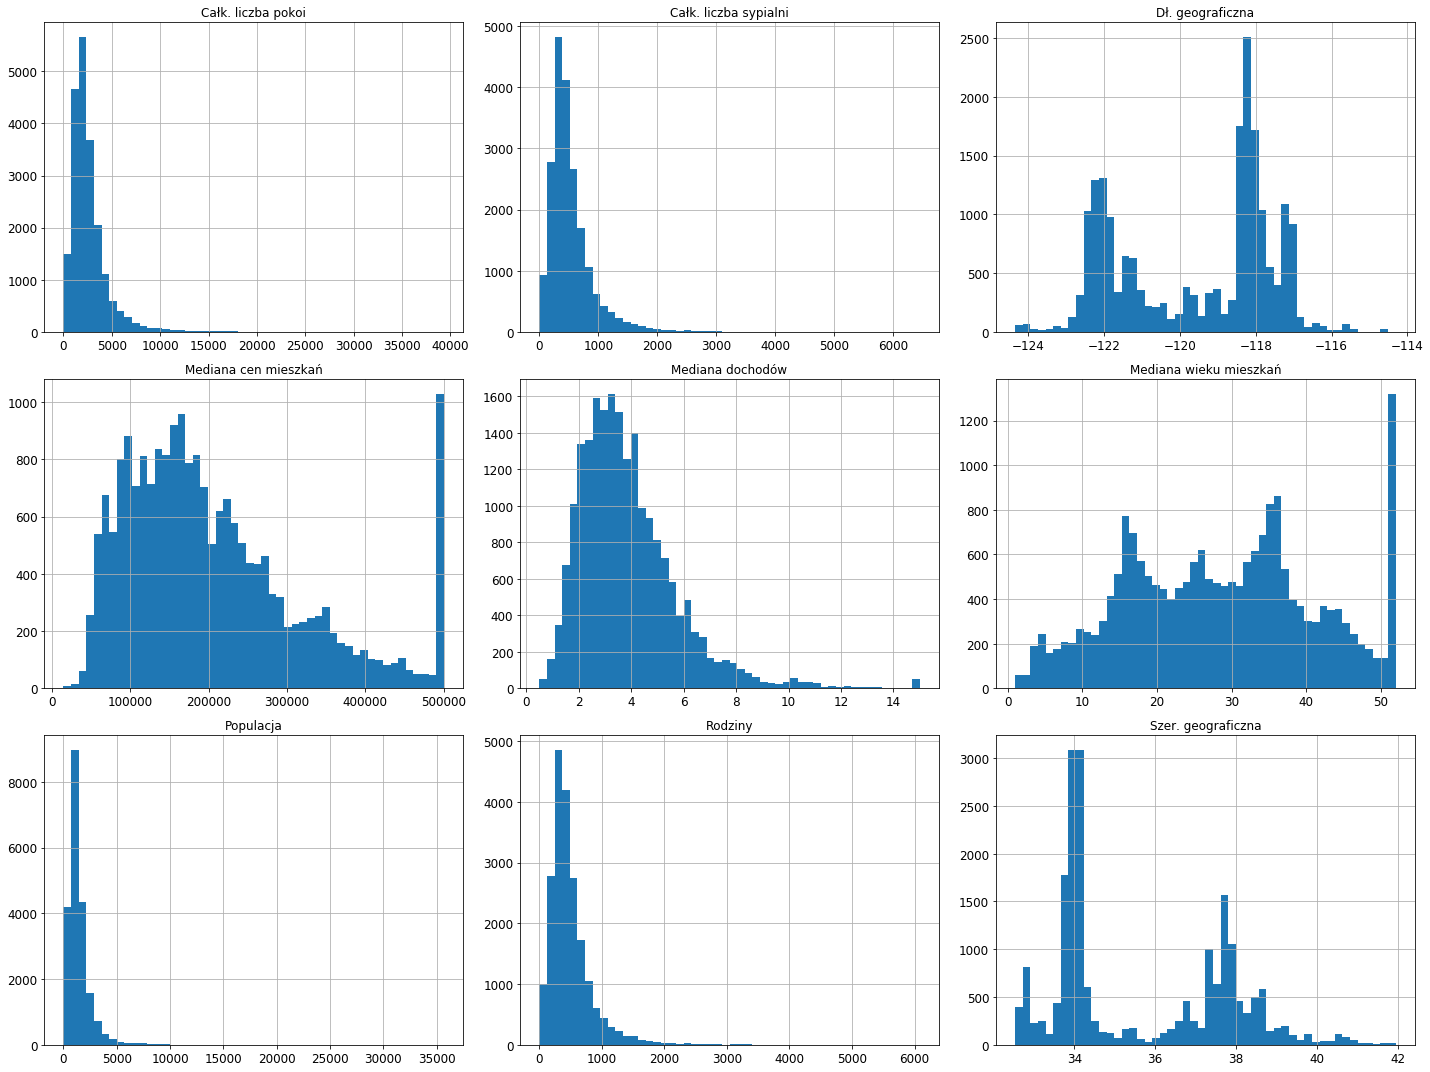

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("r_2_8")
plt.show()

In [0]:
# w celu zapewnienia powtarzalności wyników przy każdym uruchomieniu notatniku
np.random.seed(42)

In [0]:
import numpy as np

# Jedynie w celach ilustracyjnych. Moduł Sklearn zawiera funkcję train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [12]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [13]:
len(test_set)

4128

In [0]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

Powyższa implementacja funkcji `test_set_check()` działa zarówno w środowisku Python 2, jak i Python 3. We wcześniejszych wydaniach zaproponowałem poniższą implementację obsługującą dowolną funkcję mieszającą, ale była ona znacznie wolniejsza i nie była obsługiwana w środowisku Python 2:

In [0]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

Jeżeli zależy Ci na implementacji obsługującej dowolną funkcję mieszającą, zgodnej ze środowiskiem Python 2 oraz Python 3, została ona zaprezentowana poniżej:

In [0]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [17]:
housing_with_id = housing.reset_index()   # Dodaje kolumnę `index`
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
housing_with_id.rename(columns={"index": "Indeks"})

,Indeks,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [18]:
housing_with_id["id"] = housing["Dł. geograficzna"] * 1000 + housing["Szer. geograficzna"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
housing_with_id.rename(columns={"index": "Indeks", "id": "Identyfikator"})

,Indeks,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu,Identyfikator
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15
...,...,...,...,...,...,...,...,...,...,...,...,...
20635,20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,-121050.52
20636,20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,-121170.51
20637,20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,-121180.57
20638,20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,-121280.57


In [19]:
test_set.head()

,index,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [0]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [21]:
test_set.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Odległość do oceanu
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


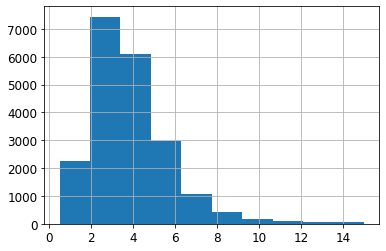

In [22]:
housing["Mediana dochodów"].hist()

In [0]:
housing["kat_dochodów"] = pd.cut(housing["Mediana dochodów"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [24]:
housing["kat_dochodów"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: kat_dochodów, dtype: int64

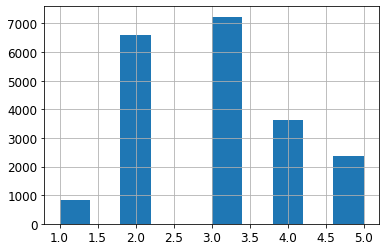

In [25]:
housing["kat_dochodów"].hist()

In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["kat_dochodów"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [27]:
strat_test_set["kat_dochodów"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: kat_dochodów, dtype: float64

In [28]:
housing["kat_dochodów"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: kat_dochodów, dtype: float64

In [0]:
def income_cat_proportions(data):
    return data["kat_dochodów"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Łącznie": income_cat_proportions(housing),
    "L. warstwowe": income_cat_proportions(strat_test_set),
    "Losowe": income_cat_proportions(test_set),
}).sort_index()
compare_props["Błąd - losowe (%)"] = 100 * compare_props["Losowe"] / compare_props["Łącznie"] - 100
compare_props["Błąd - l. warstwowe (%)"] = 100 * compare_props["L. warstwowe"] / compare_props["Łącznie"] - 100

In [30]:
compare_props

,Łącznie,L. warstwowe,Losowe,Błąd - losowe (%),Błąd - l. warstwowe (%)
1,0.039826,0.039729,0.040213,0.973236,-0.243309
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114583,0.109496,-4.318374,0.127011


In [0]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("kat_dochodów", axis=1, inplace=True)

# Odkrywanie i wizualizowanie danych w celu zdobywania nowych informacji

In [0]:
housing = strat_train_set.copy()

Zapisywanie rysunku r_2_11


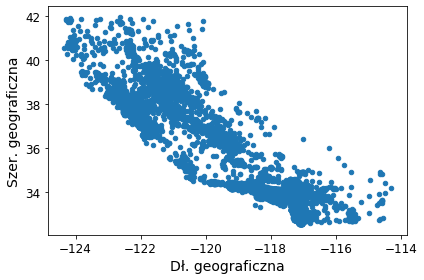

In [33]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna")
save_fig("r_2_11")

Zapisywanie rysunku r_2_12


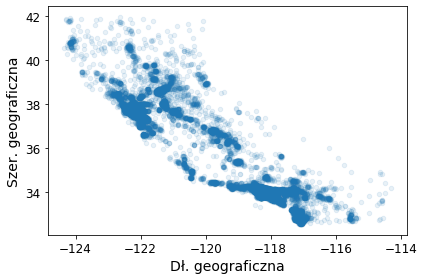

In [34]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", alpha=0.1)
save_fig("r_2_12")

Argument `sharex=False` usuwa błąd wyświetlania (nie były wyświetlane wartości osi x i legenda). Jest to tymczasowe rozwiązanie (patrz https://github.com/pandas-dev/pandas/issues/10611). Podziękowania dla Wilmera Arellano za wskazanie tego błędu.

Zapisywanie rysunku r_2_13


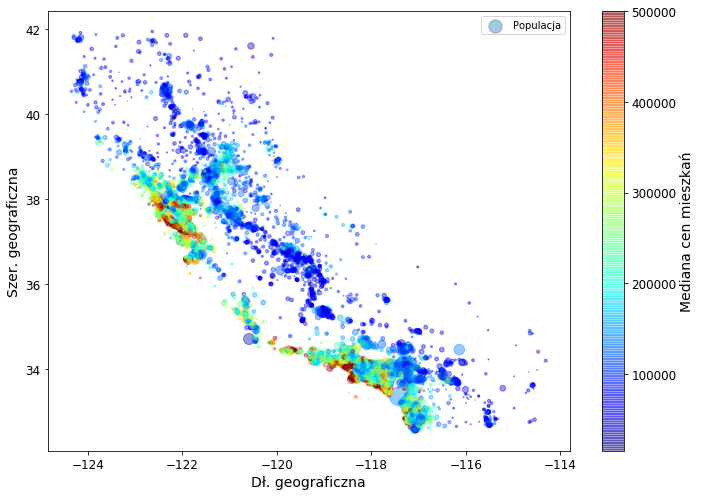

In [35]:
housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", alpha=0.4,
    s=housing["Populacja"]/100, label="Populacja", figsize=(10,7),
    c="Mediana cen mieszkań", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()
save_fig("r_2_13")

In [36]:
# Pobiera obraz mapy Kalifornii
images_path = os.path.join(PROJECT_ROOT_DIR, "rysunki", "R02")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Pobieranie pliku", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

Pobieranie pliku california.png


('./rysunki/R02/california.png', <http.client.HTTPMessage at 0x7f5461278eb8>)

Zapisywanie rysunku Ceny_mieszkań_nałożone_na_mapę


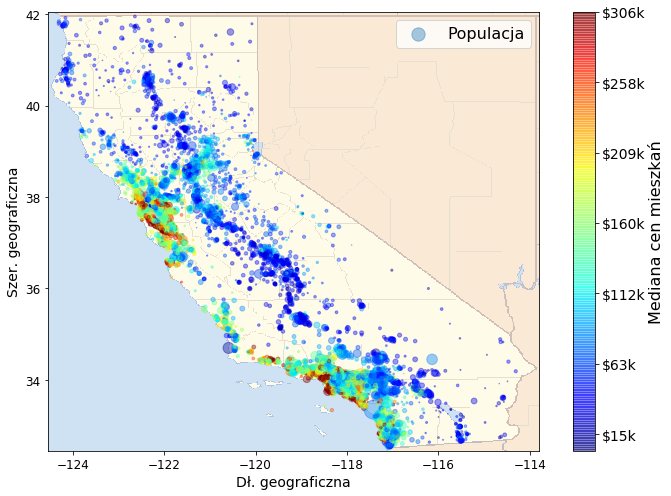

In [37]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="Dł. geograficzna", y="Szer. geograficzna", figsize=(10,7),
                       s=housing['Populacja']/100, label="Populacja",
                       c="Mediana cen mieszkań", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Szer. geograficzna", fontsize=14)
plt.xlabel("Dł. geograficzna", fontsize=14)

prices = housing["Mediana cen mieszkań"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Mediana cen mieszkań', fontsize=16)

plt.legend(fontsize=16)
save_fig("Ceny_mieszkań_nałożone_na_mapę")
plt.show()

In [0]:
corr_matrix = housing.corr()

In [39]:
corr_matrix["Mediana cen mieszkań"].sort_values(ascending=False)

Mediana cen mieszkań      1.000000
Mediana dochodów          0.687160
Całk. liczba pokoi        0.135097
Mediana wieku mieszkań    0.114110
Rodziny                   0.064506
Całk. liczba sypialni     0.047689
Populacja                -0.026920
Dł. geograficzna         -0.047432
Szer. geograficzna       -0.142724
Name: Mediana cen mieszkań, dtype: float64

Zapisywanie rysunku r_2_15


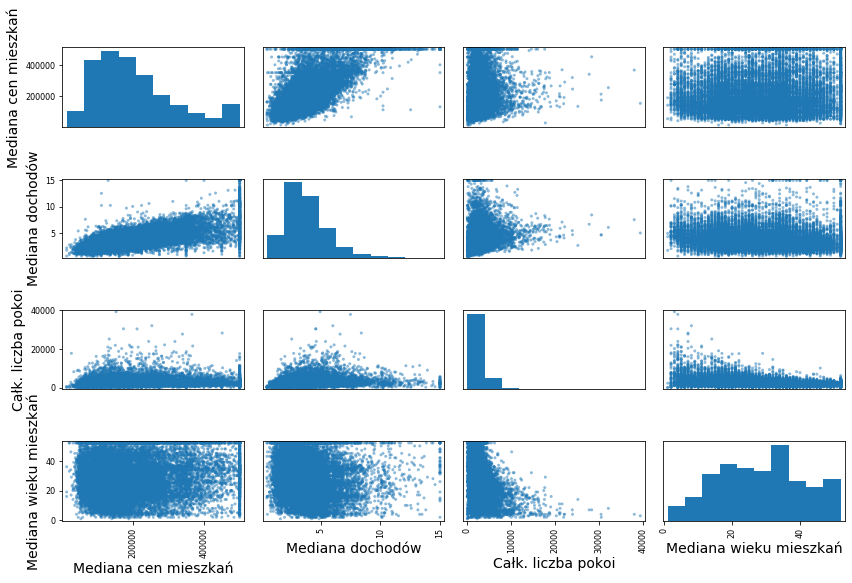

In [40]:
#from pandas.tools.plotting import scatter_matrix # Dla starszych wersji środowiska Pandas
from pandas.plotting import scatter_matrix

attributes = ["Mediana cen mieszkań", "Mediana dochodów", "Całk. liczba pokoi",
              "Mediana wieku mieszkań"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("r_2_15")

Zapisywanie rysunku r_2_16


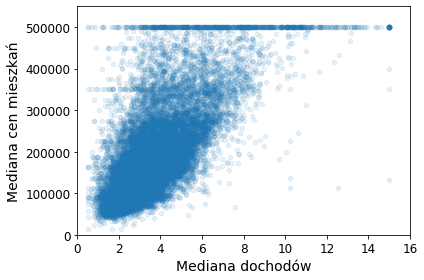

In [41]:
housing.plot(kind="scatter", x="Mediana dochodów", y="Mediana cen mieszkań",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("r_2_16")

In [0]:
housing["Pokoje_na_rodzinę"] = housing["Całk. liczba pokoi"]/housing["Rodziny"]
housing["Sypialnie_na_pokoje"] = housing["Całk. liczba sypialni"]/housing["Całk. liczba pokoi"]
housing["Populacja_na_rodzinę"]=housing["Populacja"]/housing["Rodziny"]

In [43]:
corr_matrix = housing.corr()
corr_matrix["Mediana cen mieszkań"].sort_values(ascending=False)

Mediana cen mieszkań      1.000000
Mediana dochodów          0.687160
Pokoje_na_rodzinę         0.146285
Całk. liczba pokoi        0.135097
Mediana wieku mieszkań    0.114110
Rodziny                   0.064506
Całk. liczba sypialni     0.047689
Populacja_na_rodzinę     -0.021985
Populacja                -0.026920
Dł. geograficzna         -0.047432
Szer. geograficzna       -0.142724
Sypialnie_na_pokoje      -0.259984
Name: Mediana cen mieszkań, dtype: float64

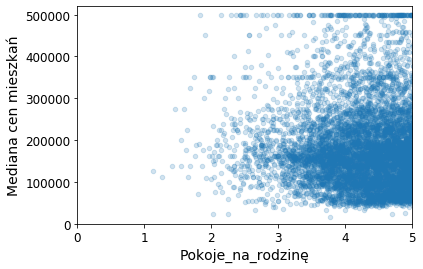

In [44]:
housing.plot(kind="scatter", x="Pokoje_na_rodzinę", y="Mediana cen mieszkań",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [45]:
housing.describe()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Mediana cen mieszkań,Pokoje_na_rodzinę,Sypialnie_na_pokoje,Populacja_na_rodzinę
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575834,35.639577,28.653101,2622.728319,534.973890,1419.790819,497.060380,3.875589,206990.920724,5.440341,0.212878,3.096437
std,2.001860,2.138058,12.574726,2138.458419,412.699041,1115.686241,375.720845,1.904950,115703.014830,2.611712,0.057379,11.584826
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566775,119800.000000,4.442040,0.175304,2.431287
50%,-118.510000,34.260000,29.000000,2119.500000,433.000000,1164.000000,408.000000,3.540900,179500.000000,5.232284,0.203031,2.817653
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.250000,602.000000,4.744475,263900.000000,6.056361,0.239831,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# Przygotowanie danych pod algorytmy uczenia maszynowego

In [0]:
housing = strat_train_set.drop("Mediana cen mieszkań", axis=1) # usuwa etykiety w zbiorze uczącym
housing_labels = strat_train_set["Mediana cen mieszkań"].copy()

In [47]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,NaN,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,NaN,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,NaN,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,NaN,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,NaN,3468.0,1405.0,3.1662,<1H OCEAN


In [48]:
sample_incomplete_rows.dropna(subset=["Całk. liczba sypialni"])    # pierwsza możliwość

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu


In [49]:
sample_incomplete_rows.drop("Całk. liczba sypialni", axis=1)       # druga możliwość

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
median = housing["Całk. liczba sypialni"].median()
sample_incomplete_rows["Całk. liczba sypialni"].fillna(median, inplace=True) # trzecia możliwość

In [51]:
sample_incomplete_rows

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708,<1H OCEAN
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762,<1H OCEAN
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328,<1H OCEAN
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675,INLAND
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662,<1H OCEAN


In [0]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

Usuwamy atrybut tekstowy, ponieważ mediana może być obliczana wyłącznie wobec atrybutów numerycznych:

In [0]:
housing_num = housing.drop('Odległość do oceanu', axis=1)
# ewentualnie: housing_num = housing.select_dtypes(include=[np.number])

In [54]:
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [55]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Sprawdzamy, czy uzyskany wynik jest taki sam, jak ręczne obliczenie mediany każdego atrybutu:

In [56]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Przekształcamy zbiór uczący:

In [0]:
X = imputer.transform(housing_num)

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)

In [59]:
housing_tr.loc[sample_incomplete_rows.index.values]

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów
4629,-118.30,34.07,18.0,3759.0,433.0,3296.0,1462.0,2.2708
6068,-117.86,34.01,16.0,4632.0,433.0,3038.0,727.0,5.1762
17923,-121.97,37.35,30.0,1955.0,433.0,999.0,386.0,4.6328
13656,-117.30,34.05,6.0,2155.0,433.0,1039.0,391.0,1.6675
19252,-122.79,38.48,7.0,6837.0,433.0,3468.0,1405.0,3.1662


In [60]:
imputer.strategy

'median'

In [0]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

In [62]:
housing_tr.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Przetwórzmy wstępnie wartości cechy kategorialnej `Odległość do oceanu`:

In [63]:
housing_cat = housing[["Odległość do oceanu"]]
housing_cat.head(10)

,Odległość do oceanu
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [64]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [65]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [66]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Klasa `OneHotEncoder` zwraca domyślnie macierz rzadką, ale w razie potrzeby możemy ją przekształcić do postaci gęstej za pomocą wywołania metody `toarray()`: 

In [67]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Ewentualnie możesz wyznaczyć `sparse=False` podczas tworzenia klasy `OneHotEncoder`:

In [68]:
cat_encoder = OneHotEncoder(sparse=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [69]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

Stwórzmy niestandardowy transformator po to, aby wprowadzić dodatkowe atrybuty: 

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# indeks kolumny
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [71]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["Pokoje_na_rodzinę", "Populacja_na_rodzinę"],
    index=housing.index)
housing_extra_attribs.head()

,Dł. geograficzna,Szer. geograficzna,Mediana wieku mieszkań,Całk. liczba pokoi,Całk. liczba sypialni,Populacja,Rodziny,Mediana dochodów,Odległość do oceanu,Pokoje_na_rodzinę,Populacja_na_rodzinę
17606,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
18632,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
14650,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3230,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
3555,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


Stwórzmy teraz potok służący do wstępnej obróbki atrybutów numerycznych:

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [73]:
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["Odległość do oceanu"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [75]:
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

In [76]:
housing_prepared.shape

(16512, 16)

Dla porównania prezentuję tu stare rozwiązanie, bazujące na transformatorze `DataFrameSelector` (służącym wyłącznie do wybierania podzbioru kolumn `DataFrame` modułu Pandas) i klasie `FeatureUnion`:

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

# worzy klasę wybierającą kolumny numeryczne i kategorialne 
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

Połączmy teraz te składowe w jeden duży potok przetwarzający wstępnie zarówno cechy numeryczne, jak i kategorialne:

In [0]:
num_attribs = list(housing_num)
cat_attribs = ["Odległość do oceanu"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [0]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])

In [80]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

The result is the same as with the `ColumnTransformer`:

In [81]:
np.allclose(housing_prepared, old_housing_prepared)

True

# Dobór i uczenie modelu

In [82]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [83]:
# Przetestujmy pełen potok na kilku przykładach uczących
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Prognozy:", lin_reg.predict(some_data_prepared))

Prognozy: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


Porównajmy wyniki z rzeczywistymi wartościami:

In [84]:
print("Etykiety:", list(some_labels))

Etykiety: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [85]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [86]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [87]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001897

In [88]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [89]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

# Strojenie modelu

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [91]:
def display_scores(scores):
    print("Wyniki:", scores)
    print("Średnia:", scores.mean())
    print("Odchylenie standardowe:", scores.std())

display_scores(tree_rmse_scores)

Wyniki: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Średnia: 71407.68766037929
Odchylenie standardowe: 2439.4345041191004


In [92]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Wyniki: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Średnia: 69052.46136345083
Odchylenie standardowe: 2731.674001798344


**Uwaga**: wyznaczamy `n_estimators=100` jako zabezpieczenie na przyszłość, ponieważ w wersji 0.22 modułu Scikit-Learn taka będzie wartość domyślna (dla uproszczenia nie wspomniałem o tym w książce).

In [93]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [94]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

In [95]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Wyniki: [49519.80364233 47461.9115823  50029.02762854 52325.28068953
 49308.39426421 53446.37892622 48634.8036574  47585.73832311
 53490.10699751 50021.5852922 ]
Średnia: 50182.303100336096
Odchylenie standardowe: 2097.0810550985693


In [96]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

count       10.000000
mean     69052.461363
std       2879.437224
min      64969.630564
25%      67136.363758
50%      68156.372635
75%      70982.369487
max      74739.570526
dtype: float64

In [97]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

In [98]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # sprawdza 12 (3×4) kombinacji hiperparametrów
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # następnie sprawdza 6 (2×3) kombinacji z wyłączonym parametrem bootstrap (False)
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# przeprowadza proces uczenia na pięciu podzbiorach, czyli łącznie (12+6)*5=90 przebiegów 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

The best hyperparameter combination found:

In [99]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [100]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=8, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=30, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [101]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63669.11631261028 {'max_features': 2, 'n_estimators': 3}
55627.099719926795 {'max_features': 2, 'n_estimators': 10}
53384.57275149205 {'max_features': 2, 'n_estimators': 30}
60965.950449450494 {'max_features': 4, 'n_estimators': 3}
52741.04704299915 {'max_features': 4, 'n_estimators': 10}
50377.40461678399 {'max_features': 4, 'n_estimators': 30}
58663.93866579625 {'max_features': 6, 'n_estimators': 3}
52006.19873526564 {'max_features': 6, 'n_estimators': 10}
50146.51167415009 {'max_features': 6, 'n_estimators': 30}
57869.25276169646 {'max_features': 8, 'n_estimators': 3}
51711.127883959234 {'max_features': 8, 'n_estimators': 10}
49682.273345071546 {'max_features': 8, 'n_estimators': 30}
62895.06951262424 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54658.176157539405 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59470.40652318466 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52724.9822587892 {'bootstrap': False, 'max_features': 3, 'n_estimators'

In [102]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.081350,0.004062,0.004761,0.000256,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-3.837622e+09,-4.147108e+09,-4.196408e+09,-3.903319e+09,-4.184325e+09,-4.053756e+09,1.519591e+08,18,-1.064113e+09,-1.105142e+09,-1.116550e+09,-1.112342e+09,-1.129650e+09,-1.105559e+09,2.220402e+07
1,0.264025,0.002970,0.013299,0.000152,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-3.047771e+09,-3.254861e+09,-3.130196e+09,-2.865188e+09,-3.173856e+09,-3.094374e+09,1.327062e+08,11,-5.927175e+08,-5.870952e+08,-5.776964e+08,-5.716332e+08,-5.802501e+08,-5.818785e+08,7.345821e+06
2,0.787512,0.013548,0.036439,0.000551,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.689185e+09,-3.021086e+09,-2.948330e+09,-2.619995e+09,-2.970968e+09,-2.849913e+09,1.626875e+08,9,-4.381089e+08,-4.391272e+08,-4.371702e+08,-4.376955e+08,-4.452654e+08,-4.394734e+08,2.966320e+06
3,0.127516,0.001381,0.004734,0.000244,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.730181e+09,-3.786886e+09,-3.734515e+09,-3.418747e+09,-3.913907e+09,-3.716847e+09,1.631510e+08,16,-9.865163e+08,-1.012565e+09,-9.169425e+08,-1.037400e+09,-9.707739e+08,-9.848396e+08,4.084607e+07
4,0.424440,0.004390,0.013010,0.000969,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.666283e+09,-2.784511e+09,-2.892276e+09,-2.616813e+09,-2.948207e+09,-2.781618e+09,1.268607e+08,8,-5.097115e+08,-5.162820e+08,-4.962893e+08,-5.436192e+08,-5.160297e+08,-5.163863e+08,1.542862e+07
5,1.278151,0.013918,0.036451,0.000469,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.387153e+09,-2.588448e+09,-2.666426e+09,-2.398071e+09,-2.649316e+09,-2.537883e+09,1.214614e+08,3,-3.838835e+08,-3.880268e+08,-3.790867e+08,-4.040957e+08,-3.845520e+08,-3.879289e+08,8.571233e+06
6,0.176489,0.004043,0.004986,0.000210,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.119657e+09,-3.586319e+09,-3.592772e+09,-3.328934e+09,-3.579607e+09,-3.441458e+09,1.893056e+08,14,-9.245343e+08,-8.886939e+08,-9.353135e+08,-9.009801e+08,-8.624664e+08,-9.023976e+08,2.591445e+07
7,0.583664,0.005953,0.013418,0.000278,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.549663e+09,-2.782039e+09,-2.762720e+09,-2.521134e+09,-2.907667e+09,-2.704645e+09,1.471569e+08,6,-4.980344e+08,-5.045869e+08,-4.994664e+08,-4.990325e+08,-5.055542e+08,-5.013349e+08,3.100456e+06
8,1.769589,0.012554,0.036128,0.000956,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.370010e+09,-2.583638e+09,-2.607703e+09,-2.350953e+09,-2.661059e+09,-2.514673e+09,1.285080e+08,2,-3.838538e+08,-3.804711e+08,-3.805218e+08,-3.856095e+08,-3.901917e+08,-3.841296e+08,3.617057e+06
9,0.226479,0.000670,0.005070,0.000169,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.353504e+09,-3.348552e+09,-3.402843e+09,-3.129307e+09,-3.510047e+09,-3.348850e+09,1.241939e+08,13,-9.228123e+08,-8.553031e+08,-8.603321e+08,-8.881964e+08,-9.151287e+08,-8.883545e+08,2.750227e+07


In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [104]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.70756927707 {'max_features': 7, 'n_estimators': 180}
51389.889203389284 {'max_features': 5, 'n_estimators': 15}
50796.155224308866 {'max_features': 3, 'n_estimators': 72}
50835.13360315349 {'max_features': 5, 'n_estimators': 21}
49280.9449827171 {'max_features': 7, 'n_estimators': 122}
50774.90662363929 {'max_features': 3, 'n_estimators': 75}
50682.78888164288 {'max_features': 3, 'n_estimators': 88}
49608.99608105296 {'max_features': 5, 'n_estimators': 100}
50473.61930350219 {'max_features': 3, 'n_estimators': 150}
64429.84143294435 {'max_features': 5, 'n_estimators': 2}


In [105]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [106]:
extra_attribs = ["Pokoje_na_rodzinę", "Populacja_na_rodzinę", "Sypialnie_na_pokoje"]
#cat_encoder = cat_pipeline.named_steps["cat_encoder"] # stare rozwiązanie
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.36615898061813423, 'Mediana dochodów'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'Populacja_na_rodzinę'),
 (0.07334423551601243, 'Dł. geograficzna'),
 (0.06290907048262032, 'Szer. geograficzna'),
 (0.056419179181954014, 'Pokoje_na_rodzinę'),
 (0.053351077347675815, 'Sypialnie_na_pokoje'),
 (0.04114379847872964, 'Mediana wieku mieszkań'),
 (0.014874280890402769, 'Populacja'),
 (0.014672685420543239, 'Całk. liczba pokoi'),
 (0.014257599323407808, 'Rodziny'),
 (0.014106483453584104, 'Całk. liczba sypialni'),
 (0.010311488326303788, '<1H OCEAN'),
 (0.0028564746373201584, 'NEAR OCEAN'),
 (0.0019604155994780706, 'NEAR BAY'),
 (6.0280386727366e-05, 'ISLAND')]

In [0]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("Mediana cen mieszkań", axis=1)
y_test = strat_test_set["Mediana cen mieszkań"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [109]:
final_rmse

47730.22690385927

Moglibyśmy obliczyć 95-procentowy przedział ufności błędu RMSE dla zbioru testowego:

In [110]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45685.10470776, 49691.25001878])

Moglibyśmy własnoręcznie obliczyć ten przedział w następujący sposób:

In [111]:
m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 + confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

(45685.10470776, 49691.25001877858)

Ewentualnie moglibyśmy skorzystać z z-wyników zamiast z t-wyników:

In [112]:
zscore = stats.norm.ppf((1 + confidence) / 2)
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - zmargin), np.sqrt(mean + zmargin)

(45685.717918136455, 49690.68623889413)

# Materiały dodatkowe

## Pełen potok zawierający etapy przygotowania i prognozowania

In [113]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([210644.60459286, 317768.80697211, 210956.43331178,  59218.98886849,
       189747.55849879])

## Zapisanie stanu modelu za pomocą narzędzia joblib

In [0]:
my_model = full_pipeline_with_predictor

In [0]:
import joblib
joblib.dump(my_model, "moj_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("moj_model.pkl") # DIFF

## Przykładowe rozkłady w module SciPy w klasie `RandomizedSearchCV`

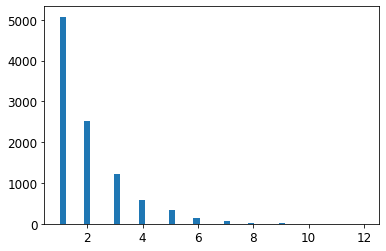

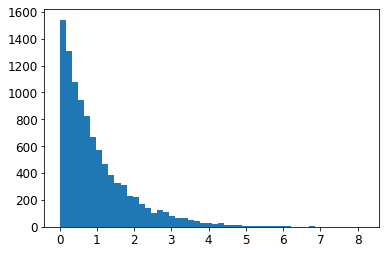

In [116]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()

# Rozwiązania ćwiczeń

## 1.

Pytanie: Wypróbuj regresor maszyny wektorów nośnych (`sklearn.svm.SVR`) przy użyciu różnych hiperparametrów, takich jak `kernel="linear"` (oraz różnych wartości hiperparametru `C`) lub `kernel="rbf"` (oraz różnych wartości hiperparametrów `C` i `gamma`). Na razie nie przejmuj się tym, że nie wiesz, do czego te hiperparametry służą. Jak się spisuje najlepszy predyktor maszyny wektorów nośnych?

In [117]:
from sklearn.model_selection import GridSearchCV

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................ C=10.0, kernel=linear, total=  10.4s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.4s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=  10.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.3s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=  10.5s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=  10.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=  10.2s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=  10.5s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 67.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

Najlepszy model uzyskuje następujący wynik (wyliczony za pomocą pięciokrotnego sprawdzianu krzyżowego): 

In [118]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

70363.84006944533

Jest to znacznie gorszy rezultat od uzyskanego za pomocą klasy `RandomForestRegressor`. Sprawdźmy, jakie najlepsze hiperparametry zostały znalezione:

In [119]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

Jądro liniowe wydaje się być lepsze od jądra RBF. Zwróć uwagę, że wartość parametru `C` stanowi maksymalną przetestowaną wartość. W takiej sytuacji zdecydowanie należy uruchomić ponownie przeszukiwanie siatki z większymi wartościami tego hiperparametru (usuwając jednocześnie mniejsze wartości), ponieważ prawdopodobnie któraś z nich będzie jeszcze lepiej dostosowana do modelu.

## 2.

Pytanie: Spróbuj zastąpić klasę `GridSearchCV` klasą `RandomizedSearchCV`.

In [120]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# na stronie https://docs.scipy.org/doc/scipy/reference/stats.html
# znajdziesz dokumentację funkcji `expon()` i `reciprocal()`, a także innych funkcji rozkładu prawdopodobieństwa.

# Uwaga: parametr gamma jest ignorowany, gdy korzystamy z jądra "linear"
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.2s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.6s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=  10.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  19.8s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  20.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=  20.4s
[CV] C=26290.2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 103.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f545e5d2400>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5457002198>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

Najlepszy model uzyskuje następujący wynik (obliczony za pomocą pięciokrotnego sprawdzianu krzyżowego):

In [121]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

54767.960710084146

Teraz uzyskaliśmy rezultat o wiele bardziej zbliżony do wydajności klasy `RandomForestRegressor` (ciągle mu jednak trochę brakuje). Przyjrzyjmy się znalezionym hiperparametrom:

In [122]:
rnd_search.best_params_

{'C': 157055.10989448498, 'gamma': 0.26497040005002437, 'kernel': 'rbf'}

Tym razem udało się znaleźć dobry zestaw hiperparametrów dla jądra RBF. Przeszukiwanie losowe zazwyczaj jest w stanie wyszukiwać w tym samym czasie lepsze hiperparametry od przeszukiwania siatki.

Sprawdźmy wykorzystany przez rozkład wykładniczy, wykorzystujący parametr `scale=1.0`. Zwróć uwagę, że niektóre próbki są znacznie większe lub mniejsze od wartości 1.0, ale gdy sprawdzimy logarytm tego rozkładu, zauważymy, że większość wartości mieści się głównie w przedziale od exp(-2) do exp(+2), czyli od mniej więcej 0.1 do 7.4.

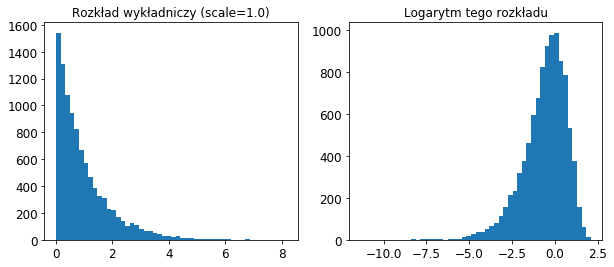

In [123]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Rozkład wykładniczy (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Logarytm tego rozkładu")
plt.hist(np.log(samples), bins=50)
plt.show()

Rozkład użyty dla hiperparametru `C` wygląda całkiem inaczej: skala próbek została wyznaczona z rozkładu jednorodnego o określonym zakresie, co stanowi powód, że wykres widoczny po prawej (reprezentujący logarytm rozkładu) jest mniej więcej jednolity. Rozkład ten przydaje się, gdy nie mamy pojęcia, jaka jest docelowa skala:

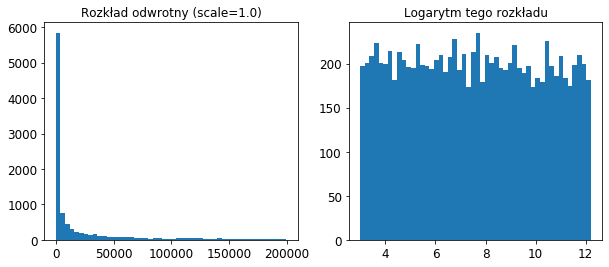

In [124]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Rozkład odwrotny (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Logarytm tego rozkładu")
plt.hist(np.log(samples), bins=50)
plt.show()

Rozkład odwrotny przydaje się wtedy, gdy nie wiemy, w jakiej skali powinien znajdować się dany hiperparametr (rzeczywiście, na prawym wykresie widzimy, że wszystkie skale mają mniej więcej takie samo prawdopodobobieństwo w określonym zakresie), natomiast rozkład wykładniczy nadaje się w sytuacjach, gdy w przybliżeniu znamy skalę hiperparametru.

## 3.

Pytanie: 	Spróbuj dodać w potoku przygotowawczym funkcję przekształcającą w taki sposób, aby były dobierane wyłącznie najistotniejsze atrybuty.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

Uwaga: Omawiany selektor cech zakłada, że już w jakiś sposób obliczyliśmy istotności cech (np. za pomocą klasy `RandomForestRegressor`). Być może kusi Cię, aby obliczyć je bezpośrednio w metodzie fit() klasy `TopFeatureSelector`, ale rozwiązanie to prawdopodobnie spowolniłoby proces przeszukiwania siatki/losowego, ponieważ istotności cech muszą zostać wyliczone dla każdej kombinacji hiperparametrów (chyba że zaimplementujesz jakąś formę pamięci podręcznej).

Zdefiniujmy liczbę najlepszych cech, które chcemy przechować:

In [0]:
k = 5

Przyjrzyjmy się teraz indeksom k najlepszych cech:

In [127]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [128]:
np.array(attributes)[top_k_feature_indices]

array(['Dł. geograficzna', 'Szer. geograficzna', 'Mediana dochodów',
       'Populacja_na_rodzinę', 'INLAND'], dtype='<U22')

Upewnijmy się, że mamy rzeczywiście do czynienia z k najlepszymi cechami:

In [129]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(0.36615898061813423, 'Mediana dochodów'),
 (0.16478099356159054, 'INLAND'),
 (0.10879295677551575, 'Populacja_na_rodzinę'),
 (0.07334423551601243, 'Dł. geograficzna'),
 (0.06290907048262032, 'Szer. geograficzna')]

Wygląda nieźle... Stwórzmy teraz nowy potok, w którym połączymy wcześniej zdefiniowany potok przygotowawczy z doborem k najlepszych cech:

In [0]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [0]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

Przyjrzyjmy się cechom trzech pierwszych próbek:

In [132]:
housing_prepared_top_k_features[0:3]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Upewnijmy się, że mamy do czynienia z k najlepszymi cechami: 

In [133]:
housing_prepared[0:3, top_k_feature_indices]

array([[-1.15604281,  0.77194962, -0.61493744, -0.08649871,  0.        ],
       [-1.17602483,  0.6596948 ,  1.33645936, -0.03353391,  0.        ],
       [ 1.18684903, -1.34218285, -0.5320456 , -0.09240499,  0.        ]])

Wszystko śmiga!  :)

## 4.

Pytanie: 	Spróbuj stworzyć pojedynczy potok przeprowadzający pełne przygotowywanie danych i generujący ostateczne prognozy.

In [0]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [135]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(memory=None,
         steps=[('preparation',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                              

Wypróbujmy pełen potok na kilku próbkach:

In [136]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Prognozy:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Etykiety:\t\t", list(some_labels))

Prognozy:	 [203214.28978849 371846.88152572 173295.65441612  47328.3970888 ]
Etykiety:		 [286600.0, 340600.0, 196900.0, 46300.0]


Wygląda na to, że pełen potok działa prawidłowo. Prognozy, oczywiście, nie są jakieś wybitne: byłyby lepsze, gdybyśmy użyli najlepszego znalezionego wcześniej regresora `RandomForestRegressor` zamiast `SVR`.

## 5.

Pytanie: 	Sprawdź automatycznie niektóre funkcje przygotowawcze za pomocą klasy `GridSearchCV`.

In [137]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s remaining:    0.0s


[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.7s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=mean 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=mean, total=  12.3s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.6s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__imputer__strategy=median, total=  12.8s
[CV] feature_selection__k=1, preparation__num__imputer__strategy=median 
[CV]  feature_selection__k=1, preparation__num__

[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 106.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        ColumnTransformer(n_jobs=None,
                                                          remainder='drop',
                                                          sparse_threshold=0.3,
                                                          transformer_weights=None,
                                                          transformers=[('num',
                                                                         Pipeline(memory=None,
                                                                                  steps=[('imputer',
                                                                                          SimpleImputer(add_indicator=False,
                                                                                                        copy=True,
                                     

In [138]:
grid_search_prep.best_params_

{'feature_selection__k': 15,
 'preparation__num__imputer__strategy': 'most_frequent'}

Najlepszą strategią klasy imputer jest `most_frequent` i najwidoczniej niemal wszystkie cechy okazują się przydatne (15 z 16). Ostatnia cecha (ISLAND) prawdopodobnie wprowadza jedynie dodatkowy szum.

Gratulacje! Wiesz już całkiem dużo na temat uczenia maszynowego. :)